In [2]:
import deepchem as dc
import pandas as pd
import numpy as np
import timeit

from sklearn.feature_selection import RFE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from numpy import average

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
#generate the list of RDKit descriptors
from rdkit.Chem import Descriptors
descriptors = Descriptors._descList

#make a list with the names of descriptors available on RDKit
descriptorlist = []
for item in descriptors:
    descriptorlist.append(item[0])

#this is done since RDKit utility in deepchem calculates the descriptors in alphabetical order,
# this way we can later extract the used descriptors
descriptorlist = sorted(descriptorlist)

#function to get the names of the descriptors based on the support vector
def Get_Selected_features(support,descriptorlist):
    for idx, bool in enumerate(support):
        if bool == True:
            print(descriptorlist[idx])

In [4]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader1 = dc.data.CSVLoader(["Density"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors(descriptorlist))
Data1 = loader1.create_dataset('./csv_files/dens_combined.csv')

loading the data...


In [5]:
#some RDKit descriptors return nan, make these 0

X1 = np.nan_to_num(Data1.X, copy=True, nan=0.0)
#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X1, y=Data1.y, w=Data1.w, ids=Data1.ids, tasks = ["Density"])


In [6]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [7]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted


In [8]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set r2_score:',test_score )

#calculate RMSE score
from sklearn.metrics import root_mean_squared_error
RMSE_score = root_mean_squared_error(test_dataset.y,predicted)
print('tets set RMSE_score:',RMSE_score)

Training set score: {'pearson_r2_score': 0.9999999964002564}
Test set r2_score: {'pearson_r2_score': 0.9999929647954436}
tets set RMSE_score: 0.0001409764763419788


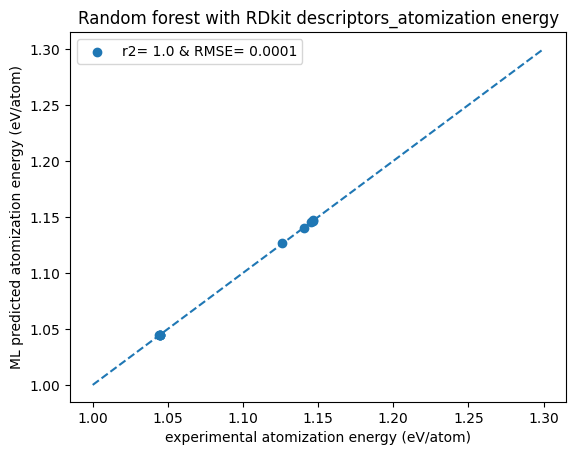

In [9]:
#convert tekst to string, so it can be depicted in matplotlib
r2=list(test_score.values())[0]
text = "r2= "+ str(round(r2,4)) + " & RMSE= " +str(round(RMSE_score,4))


#plot the data
import matplotlib.pyplot as plt

x=[1,1.3]
y=[1,1.3]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental atomization energy (eV/atom)")
plt.ylabel("ML predicted atomization energy (eV/atom)")
plt.title("Random forest with RDkit descriptors_atomization energy")
plt.show()

Above the usefullness of the prediction model was checked, now we will see the influence of the amount of features on the performance



In [ ]:
numbers = [5,10,15,20,30,40,50,60,70,100,150,210]
for n_of_feats in numbers:
    print("\n\nnumber of feats:",n_of_feats)

    #select the features using a randomforest (decisionTreeRegressor)
    selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_of_feats, step = 150)
    X_Selected = selector.fit_transform(Dataset.X, Dataset.y.ravel()) #y is a colum vector but it needs a 1d array -> ravel fixes this
    RFEDataset = dc.data.DiskDataset.from_numpy(X=X_Selected, y=Data1.y, w=Data1.w, ids=Data1.ids, tasks = ["Eat"])

    #find which descriptors are the most important
    selected = selector.support_ #this returns an array with true and false, True are the selected features
    Get_Selected_features(selected,descriptorlist)
    
    
    r2_scores =[]
    rmse_scores = []
    start = timeit.default_timer()
    #repeat the measurement 10 times
    for i in range(10):
        
        #split the dataset using the random splitter
        splitter = dc.splits.RandomSplitter()
        train_dataset, test_dataset = splitter.train_test_split(RFEDataset)
        
        # create the GPR model & fit the model
        kernel = 1 * RationalQuadratic()
        model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200))
        model.fit(train_dataset)

        #predict the test set
        predicted = model.predict(test_dataset)

        #calculate r2 score
        metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
        test_score= model.evaluate(test_dataset, metric)
        r2_scores.append(list(test_score.values())[0])

        #calculate RMSE score
        from sklearn.metrics import root_mean_squared_error
        RMSE_score = root_mean_squared_error(test_dataset.y,predicted)
        rmse_scores.append(RMSE_score)

        
    stop = timeit.default_timer()
    print("\naverage r2_score:",average(r2_scores))
    print("average rmse_score:",average(rmse_scores))
    print("Time:",stop-start)

from the tests we saw that 5 geatures predict the density pretty good, so we are going to use these five features:


BCUT2D_CHGLO/
BCUT2D_MRLOW/
Chi0/
MaxAbsPartialCharge/
NumHAcceptors/

and tried to replicate the results!


In [13]:
#load the dataset (polymer smiles and their energy of atomization)
descriptors = ["BCUT2D_CHGLO",
"BCUT2D_MRLOW",
"Chi0",
"MaxAbsPartialCharge",
"NumHAcceptors"
]
print("loading the data...")
loader1 = dc.data.CSVLoader(["Density"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors(descriptors))
Data1 = loader1.create_dataset('./csv_files/dens_combined.csv')

loading the data...


Data is splitted into: train, valid, test
fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted
Training set score: {'pearson_r2_score': 0.999999995453767}
Test set r2_score: {'pearson_r2_score': 0.9999931673265633}
tets set RMSE_score: 0.0001355348666964524


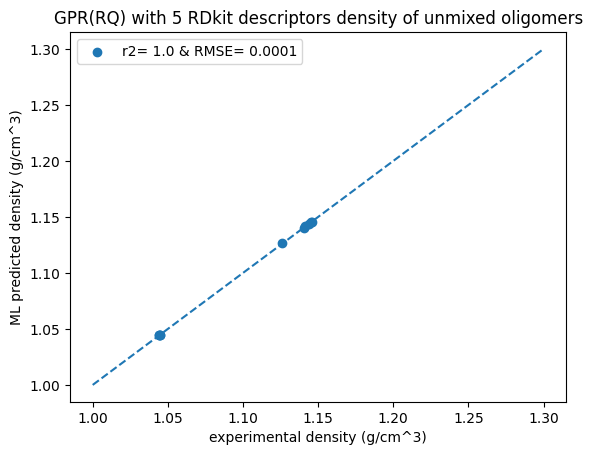

In [22]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set r2_score:',test_score )

#calculate RMSE score
from sklearn.metrics import root_mean_squared_error
RMSE_score = root_mean_squared_error(test_dataset.y,predicted)
print('tets set RMSE_score:',RMSE_score)

#convert tekst to string, so it can be depicted in matplotlib
r2=list(test_score.values())[0]
text = "r2= "+ str(round(r2,4)) + " & RMSE= " +str(round(RMSE_score,4))


#plot the data
import matplotlib.pyplot as plt

x=[1,1.3]
y=[1,1.3]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental density (g/cm^3)")
plt.ylabel("ML predicted density (g/cm^3)")
plt.title("GPR(RQ) with 5 RDkit descriptors density of unmixed oligomers")
plt.show()